**Sistema de detecção do Alfabeto em Libras - Língua Brasileira de Sinais**

Nosso sistema deve ser capaz de detectar a região que representa a face, dando suporte para o sistema de classificação reconhecer qual a letra a pessoa está fazendo em questão.

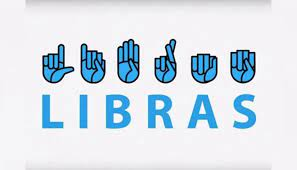

### Step 1: Captura do Sinal

Importando bibliotecas e requerimentos necessários 

In [45]:

import imutils #redimencionamento, rotacao
import numpy as np
import cv2 #import OpenCV
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript #webcan leitura
from google.colab.output import eval_js #webcan leitura
from base64 import b64decode #biblioteca para codificar dados binários

*Start* webcam

In [47]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Clique em 'Capturar' para fazer a foto usando sua webcam.

---





In [48]:
image_file = take_photo()

<IPython.core.display.Javascript object>

Leia, redimensione e exiba a imagem. 

400 300


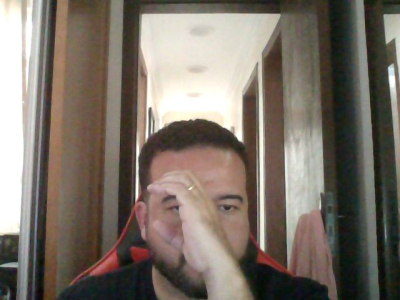

In [49]:
image = cv2.imread(image_file)

# redimensiona para ter uma largura máxima de 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

O detector de face em Deep Learning do OpenCV é baseado na estrutura Single Shot Detector (SSD) com uma rede base ResNet. A rede é definida e treinada usando o [Caffe Deep Learning framework](https://caffe.berkeleyvision.org/)

Baixe o modelo de detecção de rosto pré-treinado, composto por dois arquivos:

- A definição de rede (deploy.prototxt)
- Os pesos aprendidos (res10_300x300_ssd_iter_140000.caffemodel)

In [50]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2022-10-24 17:32:59--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.002s  

Last-modified header missing -- time-stamps turned off.
2022-10-24 17:32:59 (14.6 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2022-10-24 17:32:59--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

Carregar o modelo de rede de detecção facial pré-treinado do disco






In [51]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)
# net = cv2.dnn.

[INFO] loading model...


Use a função dnn.blobFromImage para construir um blob de entrada redimensionando a imagem para 300x300 pixels fixos e normalizando-a


In [52]:
# redimensiona para ter uma largura máxima de 400 pixels
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

In [53]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing object detections...


Faça um loop para as detecções e desenhe caixas ao redor dos rostos detectados

In [54]:
for i in range(0, detections.shape[2]):

	# extrair a probabilidade associada à previsão
	confidence = detections[0, 0, i, 2]

	# filtra detecções fracas garantindo que a "confiança" seja
	# maior que o limite mínimo de confiança
	if confidence > 0.5: #Nossa detecção deve ter no mínimo 50% de certeza
		# calcula as coordenadas (x, y) da caixa delimitadora do objeto
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# desenha a caixa delimitadora da face junto com a probabilidade associada
		text = "{:.2f}%".format(confidence * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

### Step 2: Classificação de Imagens

**Treinamento de Sinais**

***Importing packages***

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

***Data Loading***

***Fonte:***  https://www.kaggle.com/datasets/williansoliveira/libras

***Obs:*** Apesar de robusto, o conjunto de dados utilizado não está considerando as letras H , J , K , X , Z. Os sinais destas letras são em movimento, por issso, para o modelo atual, não serão utilizadas.

In [5]:
_URL = 'https://docs.google.com/uc?&export=download&id=1fZdqAHjvFt2y9ks1z90DhQR3lHbmjQpR&confirm=t'
zip_dir = tf.keras.utils.get_file('Libras_Alfabeto.zip', origin=_URL, extract=True)

303690709/303690709 [==============================] - 2s 0us/step


The dataset we have downloaded has the following directory structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>Libras_Alfabeto</b>
|__ <b>train</b>
    |______ <b>A</b>: [1.png, 2.png, 3.png ...1686.png]
    |______ <b>B</b>: [1.png, 2.png, 3.png ...1662.png]
    |______ <b>C</b>: [1.png, 2.png, 3.png ...1686.png]
    |______ <b>D</b>: [1.png, 2.png, 3.png ...1650.png]
    |______ ...
|__ <b>validation</b>
    |______ <b>A</b>: [1.png, 2.png, 3.png ...579.png]
    |______ <b>B</b>: [1.png, 2.png, 3.png ...562.png]
    |______ <b>C</b>: [1.png, 2.png, 3.png ...583.png]
    |______ <b>D</b>: [1.png, 2.png, 3.png ...550.png]
    |______ ...
</pre>

We can list the directories with the following terminal command:

In [6]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/Libras_Alfabeto
/root/.keras/datasets/Libras_Alfabeto/train
/root/.keras/datasets/Libras_Alfabeto/train/E
/root/.keras/datasets/Libras_Alfabeto/train/S
/root/.keras/datasets/Libras_Alfabeto/train/L
/root/.keras/datasets/Libras_Alfabeto/train/I
/root/.keras/datasets/Libras_Alfabeto/train/N
/root/.keras/datasets/Libras_Alfabeto/train/W
/root/.keras/datasets/Libras_Alfabeto/train/Q
/root/.keras/datasets/Libras_Alfabeto/train/F
/root/.keras/datasets/Libras_Alfabeto/train/Y
/root/.keras/datasets/Libras_Alfabeto/train/B
/root/.keras/datasets/Libras_Alfabeto/train/G
/root/.keras/datasets/Libras_Alfabeto/train/V
/root/.keras/datasets/Libras_Alfabeto/train/U
/root/.keras/datasets/Libras_Alfabeto/train/D
/root/.keras/datasets/Libras_Alfabeto/train/T
/root/.keras/datasets/Libras_Alfabeto/train/R
/root/.keras/datasets/Libras_Alfabeto/train/O
/root/.keras/datasets/Libras_Alfabeto/train/P
/root/.keras/datasets/Libras_Alfabeto/train/A
/root/.keras/datasets/

We'll now assign variables with the proper file path for the training and validation sets.

In [7]:
from sys import path
from IPython.lib.display import join
base_dir = os.path.join(os.path.dirname(zip_dir), 'Libras_Alfabeto')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_A_dir = os.path.join(train_dir,'A')
train_B_dir = os.path.join(train_dir,'B')
train_C_dir = os.path.join(train_dir,'C')
train_D_dir = os.path.join(train_dir,'D')
train_E_dir = os.path.join(train_dir,'E')
train_F_dir = os.path.join(train_dir,'F')
train_G_dir = os.path.join(train_dir,'G')
train_I_dir = os.path.join(train_dir,'I')
train_L_dir = os.path.join(train_dir,'L')
train_M_dir = os.path.join(train_dir,'M')
train_N_dir = os.path.join(train_dir,'N')
train_O_dir = os.path.join(train_dir,'O')
train_P_dir = os.path.join(train_dir,'P')
train_Q_dir = os.path.join(train_dir,'Q')
train_R_dir = os.path.join(train_dir,'R')
train_S_dir = os.path.join(train_dir,'S')
train_T_dir = os.path.join(train_dir,'T')
train_U_dir = os.path.join(train_dir,'U')
train_V_dir = os.path.join(train_dir,'V')
train_W_dir = os.path.join(train_dir,'W')
train_Y_dir = os.path.join(train_dir,'Y')

validation_A_dir = os.path.join(validation_dir,'A')
validation_B_dir = os.path.join(validation_dir,'B')
validation_C_dir = os.path.join(validation_dir,'C')
validation_D_dir = os.path.join(validation_dir,'D')
validation_E_dir = os.path.join(validation_dir,'E')
validation_F_dir = os.path.join(validation_dir,'F')
validation_G_dir = os.path.join(validation_dir,'G')
validation_I_dir = os.path.join(validation_dir,'I')
validation_L_dir = os.path.join(validation_dir,'L')
validation_M_dir = os.path.join(validation_dir,'M')
validation_N_dir = os.path.join(validation_dir,'N')
validation_O_dir = os.path.join(validation_dir,'O')
validation_P_dir = os.path.join(validation_dir,'P')
validation_Q_dir = os.path.join(validation_dir,'Q')
validation_R_dir = os.path.join(validation_dir,'R')
validation_S_dir = os.path.join(validation_dir,'S')
validation_T_dir = os.path.join(validation_dir,'T')
validation_U_dir = os.path.join(validation_dir,'U')
validation_V_dir = os.path.join(validation_dir,'V')
validation_W_dir = os.path.join(validation_dir,'W')
validation_Y_dir = os.path.join(validation_dir,'Y')



Understanding our data



Let's look at how many LIBRAS images we have in our training and validation directory



In [8]:

num_A_tr = len(os.listdir(train_A_dir))
num_B_tr = len(os.listdir(train_B_dir))
num_C_tr = len(os.listdir(train_C_dir))
num_D_tr = len(os.listdir(train_D_dir))
num_E_tr = len(os.listdir(train_E_dir))
num_F_tr = len(os.listdir(train_F_dir))
num_G_tr = len(os.listdir(train_G_dir))
num_I_tr = len(os.listdir(train_I_dir))
num_L_tr = len(os.listdir(train_L_dir))
num_M_tr = len(os.listdir(train_M_dir))
num_N_tr = len(os.listdir(train_N_dir))
num_O_tr = len(os.listdir(train_O_dir))
num_P_tr = len(os.listdir(train_P_dir))
num_Q_tr = len(os.listdir(train_Q_dir))
num_R_tr = len(os.listdir(train_R_dir))
num_S_tr = len(os.listdir(train_S_dir))
num_T_tr = len(os.listdir(train_T_dir))
num_U_tr = len(os.listdir(train_U_dir))
num_V_tr = len(os.listdir(train_V_dir))
num_W_tr = len(os.listdir(train_W_dir))
num_Y_tr = len(os.listdir(train_Y_dir))

num_A_val = len(os.listdir(validation_A_dir))
num_B_val = len(os.listdir(validation_B_dir))
num_C_val = len(os.listdir(validation_C_dir))
num_D_val = len(os.listdir(validation_D_dir))
num_E_val = len(os.listdir(validation_E_dir))
num_F_val = len(os.listdir(validation_F_dir))
num_G_val = len(os.listdir(validation_G_dir))
num_I_val = len(os.listdir(validation_I_dir))
num_L_val = len(os.listdir(validation_L_dir))
num_M_val = len(os.listdir(validation_M_dir))
num_N_val = len(os.listdir(validation_N_dir))
num_O_val = len(os.listdir(validation_O_dir))
num_P_val = len(os.listdir(validation_P_dir))
num_Q_val = len(os.listdir(validation_Q_dir))
num_R_val = len(os.listdir(validation_R_dir))
num_S_val = len(os.listdir(validation_S_dir))
num_T_val = len(os.listdir(validation_T_dir))
num_U_val = len(os.listdir(validation_U_dir))
num_V_val = len(os.listdir(validation_V_dir))
num_W_val = len(os.listdir(validation_W_dir))
num_Y_val = len(os.listdir(validation_Y_dir))



total_train= num_A_tr + num_B_tr + num_C_tr + num_D_tr + num_E_tr + num_F_tr + num_G_tr + num_I_tr + num_L_tr + num_M_tr + num_N_tr + num_O_tr + num_P_tr + num_Q_tr + num_R_tr + num_S_tr + num_T_tr + num_U_tr + num_V_tr + num_W_tr + num_Y_tr
total_val = num_A_val + num_B_val + num_C_val + num_D_val + num_E_val + num_F_val + num_G_val + num_I_val + num_L_val + num_M_val + num_N_val + num_O_val + num_P_val + num_Q_val + num_R_val + num_S_val + num_T_val + num_U_val + num_V_val + num_W_val + num_Y_val

In [9]:
print('total training sign A images:', num_A_tr)
print('total training sign B images:', num_B_tr)
print('total training sign C images:', num_C_tr)
print('total training sign D images:', num_D_tr)
print('total training sign E images:', num_E_tr)
print('total training sign F images:', num_F_tr)
print('total training sign G images:', num_G_tr)
print('total training sign I images:', num_I_tr)
print('total training sign L images:', num_L_tr)
print('total training sign M images:', num_M_tr)
print('total training sign N images:', num_N_tr)
print('total training sign O images:', num_O_tr)
print('total training sign P images:', num_P_tr)
print('total training sign Q images:', num_Q_tr)
print('total training sign R images:', num_R_tr)
print('total training sign S images:', num_S_tr)
print('total training sign T images:', num_T_tr)
print('total training sign U images:', num_U_tr)
print('total training sign V images:', num_V_tr)
print('total training sign W images:', num_W_tr)
print('total training sign Y images:', num_Y_tr)

print("--")

print('total validation sign A images:', num_A_val)
print('total validation sign B images:', num_B_val)
print('total validation sign C images:', num_C_val)
print('total validation sign D images:', num_D_val)
print('total validation sign E images:', num_E_val)
print('total validation sign F images:', num_F_val)
print('total validation sign G images:', num_G_val)
print('total validation sign I images:', num_I_val)
print('total validation sign L images:', num_L_val)
print('total validation sign M images:', num_M_val)
print('total validation sign N images:', num_N_val)
print('total validation sign O images:', num_O_val)
print('total validation sign P images:', num_P_val)
print('total validation sign Q images:', num_Q_val)
print('total validation sign R images:', num_R_val)
print('total validation sign S images:', num_S_val)
print('total validation sign T images:', num_T_val)
print('total validation sign U images:', num_U_val)
print('total validation sign V images:', num_V_val)
print('total validation sign W images:', num_W_val)
print('total validation sign Y images:', num_Y_val)


print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training sign A images: 1686
total training sign B images: 1662
total training sign C images: 1686
total training sign D images: 1650
total training sign E images: 1670
total training sign F images: 1647
total training sign G images: 1650
total training sign I images: 1650
total training sign L images: 1650
total training sign M images: 1650
total training sign N images: 1650
total training sign O images: 1650
total training sign P images: 1650
total training sign Q images: 1650
total training sign R images: 1650
total training sign S images: 1650
total training sign T images: 1614
total training sign U images: 1650
total training sign V images: 1650
total training sign W images: 1649
total training sign Y images: 1650
--
total validation sign A images: 579
total validation sign B images: 562
total validation sign C images: 583
total validation sign D images: 550
total validation sign E images: 574
total validation sign F images: 450
total validation sign G images: 550
total vali

Let's look at how many LIBRAS images we have in our training and validation directory

***Setting Model Parameters***

For convenience, we'll set up variables that will be used later while pre-processing our dataset and training our network.

In [10]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

***Data Preparation***

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

We can set this up in a couple of lines of code.

In [11]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

After defining our generators for training and validation images, flow_from_directory method will load images from the disk, apply rescaling, and resize them using single line of code.

In [12]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 34714 images belonging to 21 classes.


In [13]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 11548 images belonging to 21 classes.


***Visualizing Training images***

We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using matplotlib.

In [14]:
sample_training_images, _ = next(train_data_gen) 

The next function returns a batch from the dataset. One batch is a tuple of (many images, many labels). For right now, we're discarding the labels because we just want to look at the images.

In [15]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

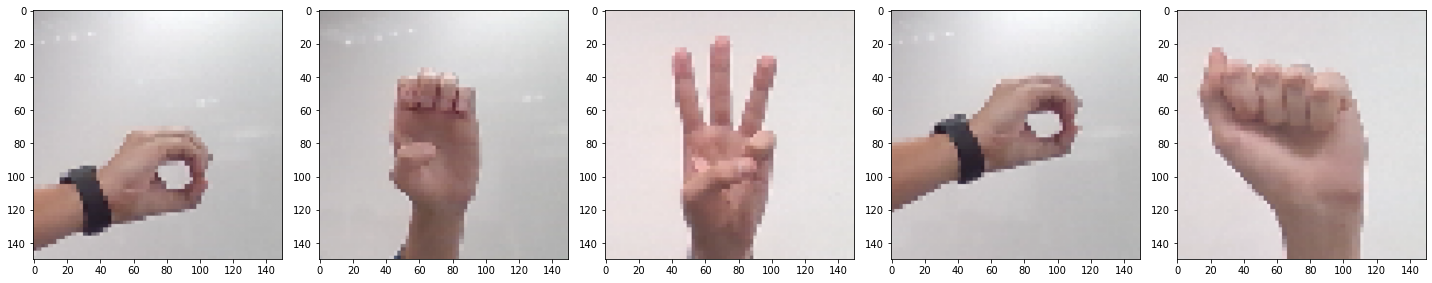

In [35]:
plotImages(sample_training_images[:5])  # Plot images 0-4

***Model Creation***

***Define the model***

The model consists of four convolution blocks with a max pool layer in each of them. Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for twenty one classes — LIBRAS — using `softmax`. 

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #tf.keras.layers.AvgPool2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),    
    tf.keras.layers.Dense(512 , activation='relu'),    
    tf.keras.layers.Dense(2)
])

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))

***Compile the model***

As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `sparse_categorical_crossentropy` as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

***Model Summary***

Let's look at all the layers of our network using **summary** method.

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

***Train the model***

It's time we train our network.

Since our batches are coming from a generator (`ImageDataGenerator`), we'll use `fit_generator` instead of `fit`.

In [25]:
#EPOCHS = 100
#EPOCHS = 50
EPOCHS = 4
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/4
348/348 [==============================] - 1813s 5s/step - loss: 3.2576 - accuracy: 0.2466 - val_loss: 2.4223 - val_accuracy: 0.4502
Epoch 2/4
348/348 [==============================] - 1745s 5s/step - loss: 1.9654 - accuracy: 0.5731 - val_loss: 2.0734 - val_accuracy: 0.5570
Epoch 3/4
348/348 [==============================] - 1854s 5s/step - loss: 1.6485 - accuracy: 0.6559 - val_loss: 1.7151 - val_accuracy: 0.6329
Epoch 4/4
348/348 [==============================] - 1717s 5s/step - loss: 1.2541 - accuracy: 0.7391 - val_loss: 1.5185 - val_accuracy: 0.6788


***Visualizing results of the training***

We'll now visualize the results we get after training our network.

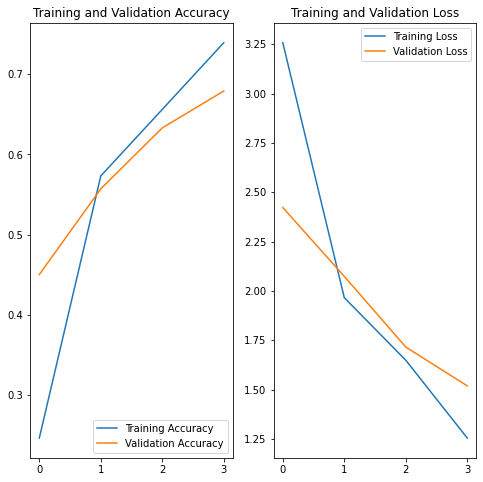

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

### Step 3: Recuperação do Sinal



***Recuperando no DATASET a imagem capturada***

In [65]:

SinalCapturado = 'C'

Sinal_Diretorio = []
Sinal_Diretorio.append('A')
Sinal_Diretorio.append('B')
Sinal_Diretorio.append('C')
Sinal_Diretorio.append('D')
Sinal_Diretorio.append('E')
Sinal_Diretorio.append('F')
Sinal_Diretorio.append('G')
Sinal_Diretorio.append('I')
Sinal_Diretorio.append('L')
Sinal_Diretorio.append('M')
Sinal_Diretorio.append('N')
Sinal_Diretorio.append('O')
Sinal_Diretorio.append('P')
Sinal_Diretorio.append('Q')
Sinal_Diretorio.append('R')
Sinal_Diretorio.append('S')
Sinal_Diretorio.append('T')
Sinal_Diretorio.append('U')
Sinal_Diretorio.append('V')
Sinal_Diretorio.append('W')
Sinal_Diretorio.append('Y')

#Sinal_Diretorio

#for i in range(val_data_gen.num_classes):
#  str.format(val_data_gen.directory,'/', Sinal_Diretorio.index(i+1))
#  #print(val_data_gen.directory + '/' +  Sinal_Diretorio.index(i+1))
#  print(str.format(val_data_gen.directory,'/', Sinal_Diretorio.index(i+1))) 

#for i in range(val_data_gen.num_classes):
#!python detect.py --weights yolov3.pt --img 640 --conf 0.25 --source data/images

  #val_data_gen.class_indices(i)
 # SinalCapturado = val_data_gen.class_indices.items(i)   (i)
  #val_data_gen.classes.
#validation_dir.


#/root/.keras/datasets/Libras_Alfabeto/validation
#val_data_gen.directory = /root/.keras/datasets/Libras_Alfabeto/validation

print(SinalCapturado)


C


**Gera resultado na tela**

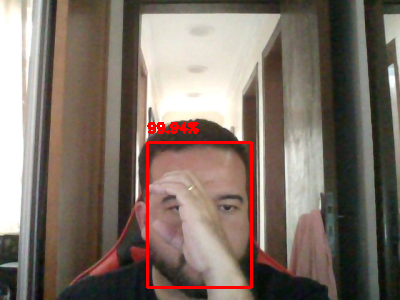

In [55]:
cv2_imshow(image)

### Step 4: Audio do Sinal Identificado


***Retorno em audio do sinal que foi identificado***


In [56]:
!pip install gTTS


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
from gtts import gTTS

text_to_say = "Letra C"

language = "pt"

gtts_object = gTTS(text = text_to_say, 
                  lang = language,
                  slow = False)

gtts_object.save("/content/gtts.wav")